##### Libraries

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('scroll_down/main')
utils.load_extension('hide_input/main')
utils.load_extension('jupyter-js-widgets/extension')


<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport

from sklearn.linear_model import Lasso,LogisticRegression

from category_encoders.one_hot import OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelBinarizer
from sklearn.metrics import mean_absolute_error, classification_report, roc_auc_score

from sklearn.tree import DecisionTreeRegressor, plot_tree
from catboost import CatBoostRegressor, CatBoostClassifier

import shap

from matplotlib import rcParams

rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

rcParams["figure.figsize"] = 16, 8

In [3]:
def plot_feature_importance(columnas,model_features,columns_ploted=10,model_name='Catboost'):
    '''
    This method is yet non-tested
    
    This function receives a set of columns feeded to a model, and the importance of each of feature.
    Returns a graphical visualization
    
    Call it fot catboost pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,pipe_best_estimator.named_steps['cb'].get_feature_importance(),20)
    
    Call it for lasso pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,np.array(pipe_best_estimator.named_steps['clf'].coef_.squeeze()),20)
    '''

    feature_importance = pd.Series(index = columnas, data = np.abs(model_features))
    n_selected_features = (feature_importance>0).sum()
    print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,(1-n_selected_features/len(feature_importance))*100))
    plt.figure()
    feature_importance.sort_values().tail(columns_ploted).plot(kind = 'bar', figsize = (18,6))
    plt.title('Feature Importance for {}'.format(model_name))
    plt.show()


In [4]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [5]:
file_path = (
    os.path.abspath(os.path.join("", "../.."))
    + "/Data/araria-osm-dhs/araria-osm-dhs.csv"
)
df = pd.read_csv(file_path)

In [6]:
file_path = (
    os.path.abspath(os.path.join("", "../.."))
    + "/Data/araria-osm-dhs/araria_voronoi_osm.csv"
)
araria = pd.read_csv(file_path)

Columns (6,7,8,9,10,12,13,14,15,18,19,21,25,26,28,29,30,31,32,33,34,35,36,37,39,40,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,68,69,70,71,72,73,74,75) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
file_path = os.path.abspath(os.path.join("", "../..")) + "/Data/DHS-PROCESSED-CLEAN.csv"
dhs = pd.read_csv(file_path)

In [8]:
data = pd.merge(araria, df, left_on="osmid", right_on="OSMID")

In [9]:
df = pd.merge(data, dhs, on="DHSCLUST")

In [10]:
del data, araria

In [11]:
df['Wealth'].unique()

array(['poorest', 'poorer'], dtype=object)

## Clean

In [12]:
df = df.drop(
    columns=[
        "Unnamed: 0_x",
        "Unnamed: 0_y",
        "geometry_x",
        "name:en",
        "nodes",
        "DHSID",
        "OSMID",
        'geometry_y',
        'geometry_x',
        'osmid',
        'Drinking Water',
        'DHSREGNA',
        'LATNUM',
        'LONGNUM'
    ]
)

In [13]:
def filter_my_way(data,columna):
    '''
    If the DHSCLUST does not have any value it will have a NaN on this 
    '''
    temp = data.groupby(['DHSCLUST',columna]).count().reset_index()
    t = temp.loc[temp.groupby('DHSCLUST').unique_id.agg('idxmax')]
    
    dic = pd.Series(t[columna].values,index=t['DHSCLUST'].values).to_dict()
    data[columna] = data['DHSCLUST'].map(dic)
    return data
    
    

In [14]:
df = filter_my_way(df,'amenity')

In [15]:
cols = ['amenity','highway','surface','motorroad','building','landuse','element_type']
for c in cols:
    df = filter_my_way(df,c)

In [16]:
df = df.loc[:, df.isnull().mean() < .9]

In [17]:
df = df.drop(columns=['unique_id'])

In [18]:
df.DHSCLUST.nunique()

58

In [19]:
df = df.drop_duplicates()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Wealth Index'>

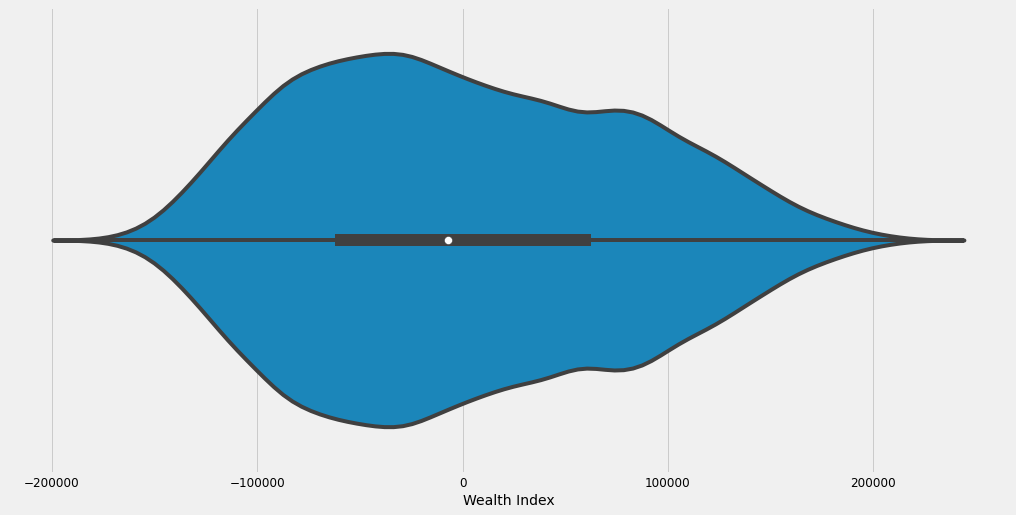

In [20]:
sns.violinplot(dhs['Wealth Index'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Wealth Index'>

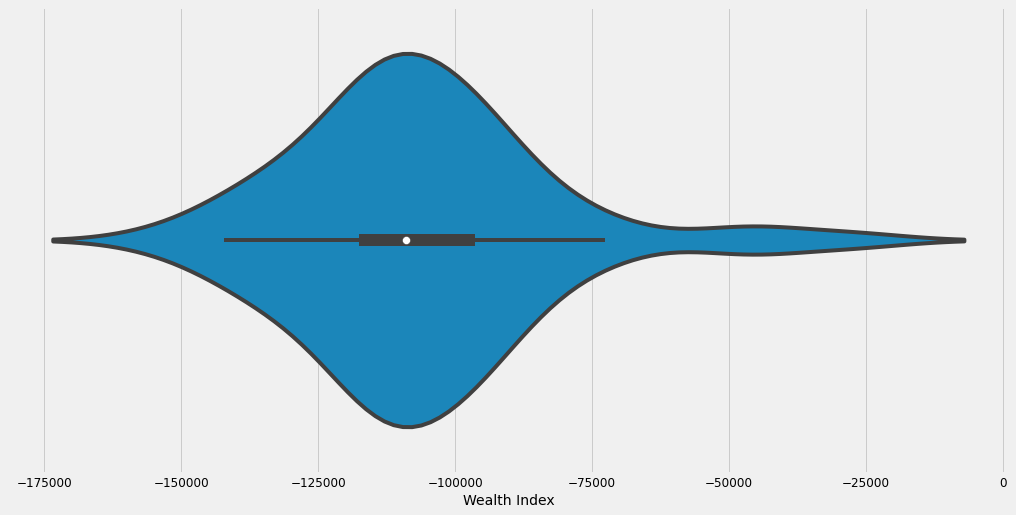

In [21]:
sns.violinplot(df['Wealth Index'])

for one district 17MB. 

In [22]:
df.shape

(58, 17)

In [23]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [24]:
#profile.to_file("DHS_OSM_EDA_report.html")

## Modeling

In [25]:
cols_drop = ['DHSCLUST','Wealth Index','DISTRICTID','Wealth']

scaler = MinMaxScaler()
df[["UN_Population_Density_2015"]] = scaler.fit_transform(
    df[["UN_Population_Density_2015"]]
)

X = df.drop(columns=cols_drop)
y = df[["Wealth Index"]]

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


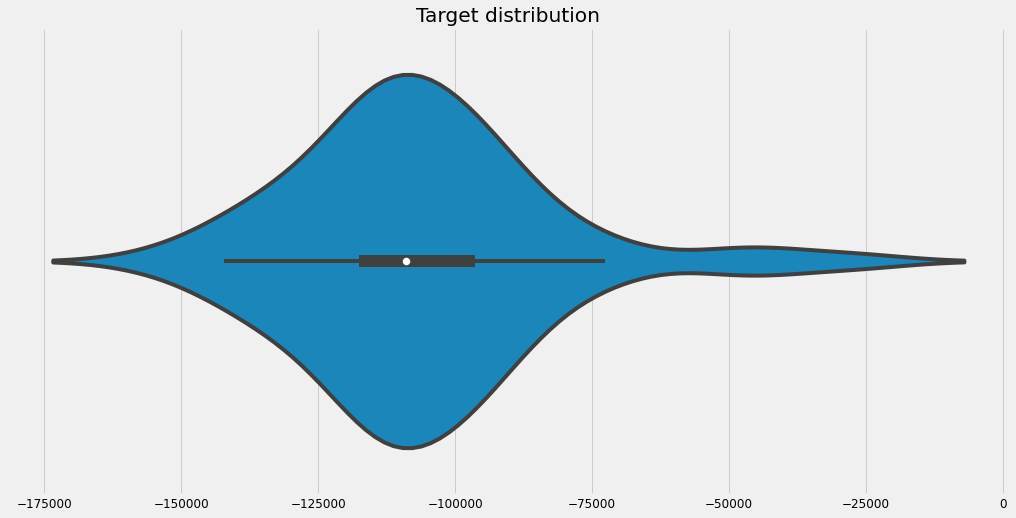

In [26]:
plt.figure()
plt.title('Target distribution')
sns.violinplot(y.values)
plt.show()

In [27]:
X

,element_type,amenity,highway,landuse,building,Toilet Facility,Roof Material,Electricity,Cooking Fuel,URBAN_RURA,ADM1NAME,UN_Population_Density_2015,Population_Density
0,way,hospital,NaN,residential,yes,No Facility,Metal,no,Dung,R,Bihar,0.562161,Very High
6,node,hospital,NaN,NaN,yes,No Facility,Metal,yes,Dung,R,Bihar,0.455582,High
8,way,hospital,NaN,NaN,yes,No Facility,Metal,no,Wood/Straw,R,Bihar,0.423391,High
15,way,NaN,NaN,forest,yes,No Facility,Metal,no,Wood/Straw,R,Bihar,0.427483,High
20,way,NaN,NaN,NaN,yes,No Facility,Metal,yes,Wood/Straw,R,Bihar,0.511117,Very High
27,way,NaN,NaN,NaN,yes,No Facility,Thatch/Palm,yes,Wood/Straw,R,Bihar,0.491431,Very High
29,way,NaN,NaN,NaN,yes,No Facility,Metal,yes,Wood/Straw,R,Bihar,0.446269,High
31,way,NaN,NaN,NaN,yes,No Facility,Metal,yes,Dung,R,Bihar,0.488783,Very High
39,way,NaN,NaN,NaN,yes,No Facility,Metal,no,Wood/Straw,R,Bihar,0.349551,High
49,way,NaN,NaN,NaN,yes,No Facility,Metal,yes,Crops,R,Bihar,0.573718,Very High


In [28]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y)

### Regression

#### Linear OHE

In [29]:
model = Lasso()
enc = OneHotEncoder(use_cat_names=True)

In [30]:
pipe = Pipeline([('enc',enc), ('model',model)])

In [31]:
pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Objective did not converge. You might want to increase the number of iterations. Duality gap: 355602848.6451373, tolerance: 2120544.52316146


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['element_type', 'amenity', 'highway',
                                     'landuse', 'building', 'Toilet Facility',
                                     'Roof Material', 'Electricity',
                                     'Cooking Fuel', 'URBAN_RURA', 'ADM1NAME',
                                     'Population_Density'],
                               use_cat_names=True)),
                ('model', Lasso())])

In [32]:
mean_absolute_error(pipe.predict(X_te),y_te)

15744.092955293863

30 features, reduction of 21.05%


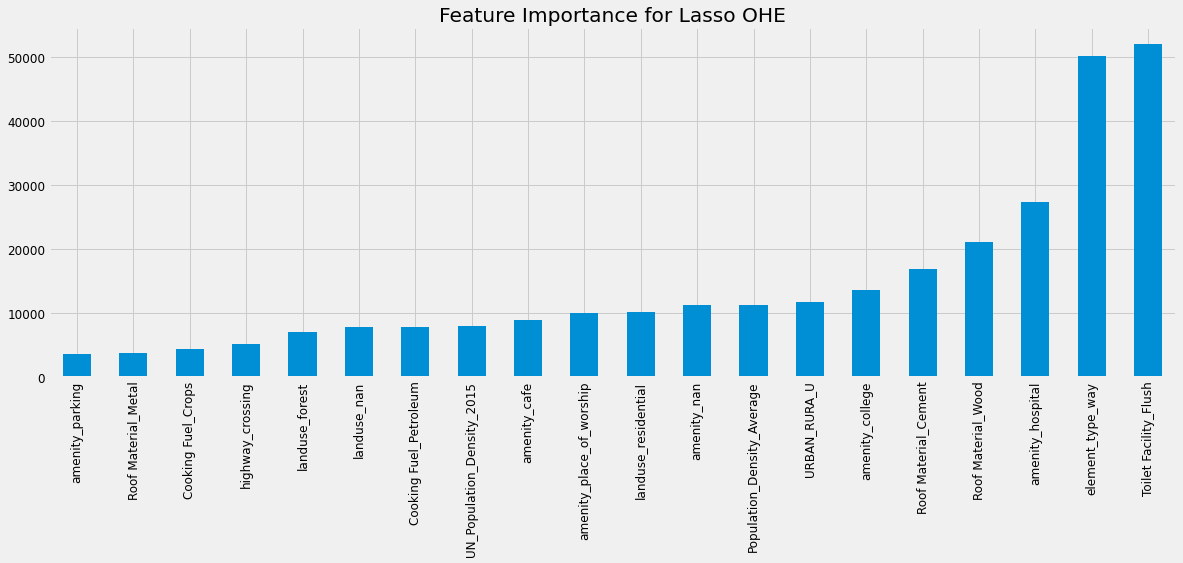

In [33]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    np.array(pipe.named_steps["model"].coef_.squeeze()),
    20,model_name='Lasso OHE'
)

#### Linear TE

In [34]:
model = Lasso()
enc = CatBoostEncoder()

pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['element_type', 'amenity', 'highway',
                                       'landuse', 'building', 'Toilet Facility',
                                       'Roof Material', 'Electricity',
                                       'Cooking Fuel', 'URBAN_RURA', 'ADM1NAME',
                                       'Population_Density'])),
                ('model', Lasso())])

In [35]:
mean_absolute_error(pipe.predict(X_te),y_te)

17310.293384865225

13 features, reduction of 0.00%


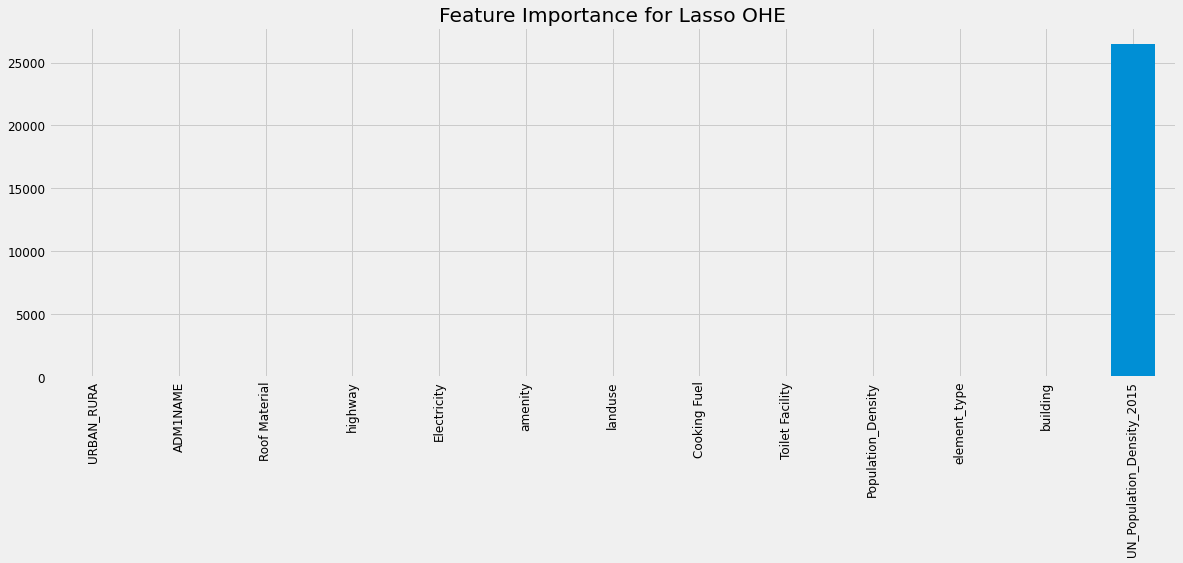

In [36]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    np.array(pipe.named_steps["model"].coef_.squeeze()),
    20,model_name='Lasso OHE'
)

#### Decision Tree TE

In [37]:
model = DecisionTreeRegressor(max_depth=5)
enc = CatBoostEncoder()

pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['element_type', 'amenity', 'highway',
                                       'landuse', 'building', 'Toilet Facility',
                                       'Roof Material', 'Electricity',
                                       'Cooking Fuel', 'URBAN_RURA', 'ADM1NAME',
                                       'Population_Density'])),
                ('model', DecisionTreeRegressor(max_depth=5))])

In [38]:
mean_absolute_error(pipe.predict(X_te),y_te)

15479.958118781806

In [39]:
pipe.named_steps["model"]

DecisionTreeRegressor(max_depth=5)

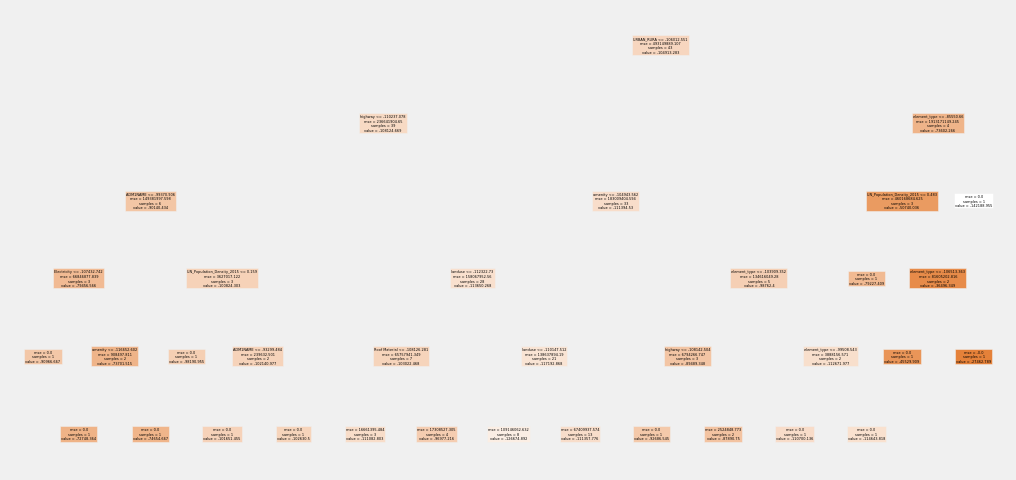

In [40]:
plt.figure()
plot_tree(
    pipe.named_steps["model"],
    max_depth=5,
    feature_names=X_tr.columns,
    filled=True,
)
plt.savefig('tree_te.svg',format='svg')
plt.show()

#### Decision Tree OHE

In [41]:
model = DecisionTreeRegressor(max_depth=8)
enc = OneHotEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['element_type', 'amenity', 'highway',
                                     'landuse', 'building', 'Toilet Facility',
                                     'Roof Material', 'Electricity',
                                     'Cooking Fuel', 'URBAN_RURA', 'ADM1NAME',
                                     'Population_Density'])),
                ('model', DecisionTreeRegressor(max_depth=8))])

In [42]:
mean_absolute_error(pipe.predict(X_te),y_te)

15271.906118326118

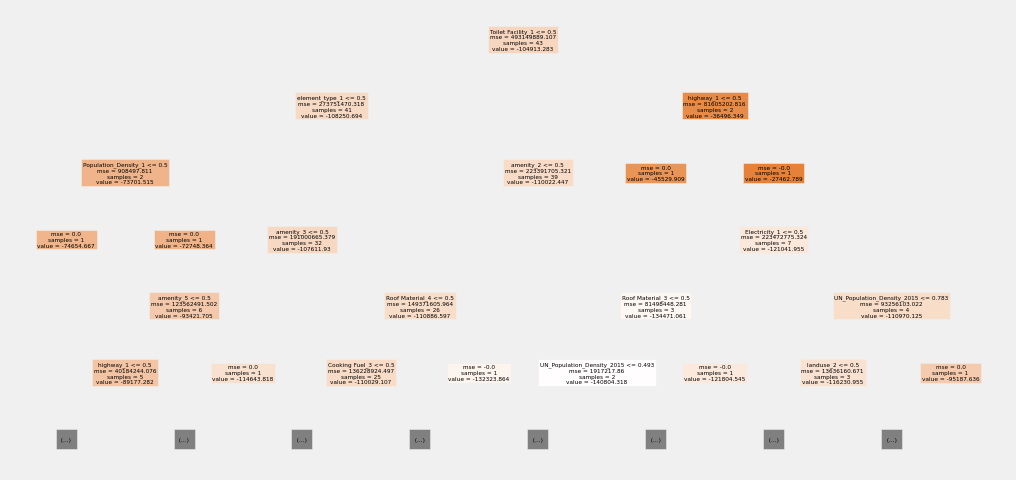

In [43]:
plt.figure()
plot_tree(
    pipe.named_steps["model"],
    max_depth=5,
    feature_names=pipe[:-1].transform(X_tr).columns,
    filled=True,
)
plt.savefig('tree_ohe.svg',format='svg')
plt.show()

#### Catboost TE

In [44]:
model = CatBoostRegressor(iterations=200,verbose=0)
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['element_type', 'amenity', 'highway',
                                       'landuse', 'building', 'Toilet Facility',
                                       'Roof Material', 'Electricity',
                                       'Cooking Fuel', 'URBAN_RURA', 'ADM1NAME',
                                       'Population_Density'])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fdfd4457f70>)])

In [45]:
mean_absolute_error(pipe.predict(X_te),y_te)

16601.2978098017

13 features, reduction of 0.00%


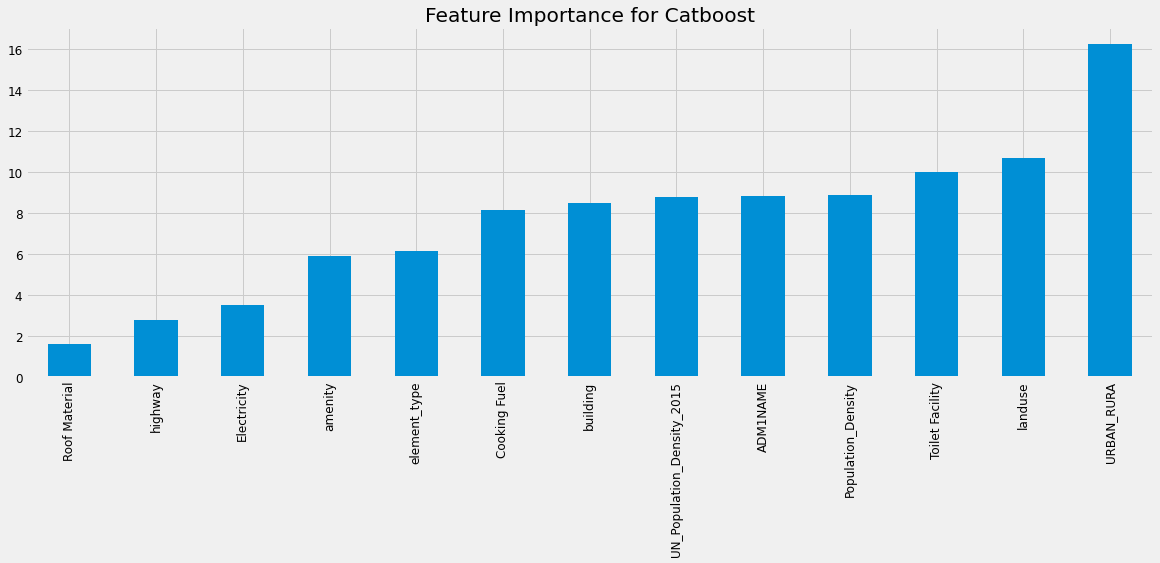

In [46]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

In [47]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

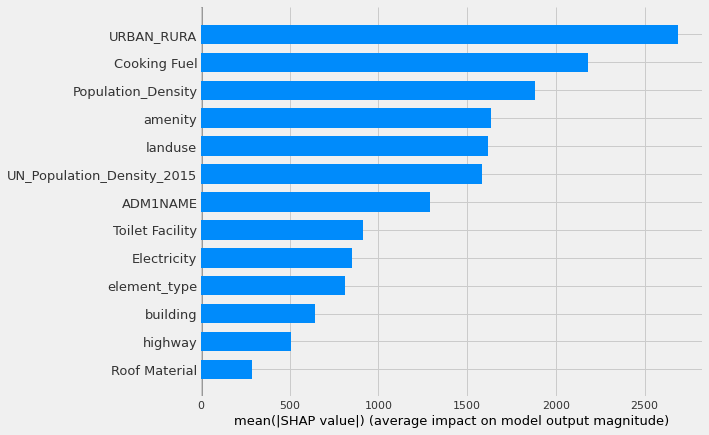

In [48]:
shap.summary_plot(shap_values, X_te, plot_type="bar")

## Classification

In [49]:
X = df.drop(columns=cols_drop)
y = df[["Wealth"]]

dic = {"richest": 1, "richer": 2, "middle": 3, "poorer": 4, "poorest": 5}
y = y.Wealth.map(dic)

X_tr,X_te,y_tr,y_te = train_test_split(X,y)

#### Logistic TE

In [50]:
model = LogisticRegression()
enc = OneHotEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['element_type', 'amenity', 'highway',
                                     'landuse', 'building', 'Toilet Facility',
                                     'Roof Material', 'Electricity',
                                     'Cooking Fuel', 'URBAN_RURA', 'ADM1NAME',
                                     'Population_Density'])),
                ('model', LogisticRegression())])

In [51]:
roc_auc_score(pipe.predict(X_te),y_te)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
print(classification_report(pipe.predict(X_te),y_te))

In [ ]:
df.shape

In [ ]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].coef_.squeeze(),
    20,
)

## Converted Regression

#### Lasso TE

In [ ]:
model = Lasso()
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

In [ ]:
mean_absolute_error(pipe.predict(X_te),y_te)

In [ ]:
preds = np.round(pipe.predict(X_te))
dic_rev = {v: k for k, v in dic.items()}
preds = pd.DataFrame(preds,columns=['predictions'])
y_test = preds.predictions.map(dic_rev)

In [ ]:
print(classification_report(y_test,[dic_rev[k] for k in y_te]))

In [ ]:
multiclass_roc_auc_score(y_test,[dic_rev[k] for k in y_te],average=None)

In [ ]:
df.shape

In [ ]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values, X_te, plot_type="bar")

In [ ]:
#### Catboost TE

model = CatBoostRegressor(iterations=200,verbose=0)
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

mean_absolute_error(pipe.predict(X_te),y_te)

preds = np.round(pipe.predict(X_te))
dic_rev = {v: k for k, v in dic.items()}
preds = pd.DataFrame(preds,columns=['predictions'])
y_test = preds.predictions.map(dic_rev)

print(classification_report(y_test,[dic_rev[k] for k in y_te]))

multiclass_roc_auc_score(y_test,[dic_rev[k] for k in y_te],average=None)

df.shape

plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

shap.summary_plot(shap_values, X_te, plot_type="bar")

#### Catboost TE

In [ ]:
model = CatBoostRegressor(iterations=200,verbose=0)
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

In [ ]:
mean_absolute_error(pipe.predict(X_te),y_te)

In [ ]:
preds = np.round(pipe.predict(X_te))
dic_rev = {v: k for k, v in dic.items()}
preds = pd.DataFrame(preds,columns=['predictions'])
y_test = preds.predictions.map(dic_rev)

In [ ]:
print(classification_report(y_test,[dic_rev[k] for k in y_te]))

In [ ]:
multiclass_roc_auc_score(y_test,[dic_rev[k] for k in y_te],average=None)

In [ ]:
df.shape

In [ ]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values, X_te, plot_type="bar")